In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

import json
import random
import time
import math
from ast import literal_eval as make_tuple
# import psutil
from utils import mnist_reader
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR='data/fashion/'
train, y_train = mnist_reader.load_mnist(path=DATA_DIR, kind='train')
test, y_test = mnist_reader.load_mnist(path=DATA_DIR, kind='t10k')

In [3]:
class PCA:
    def __init__(self,n_components,*args):
        self.n=n_components
    def fit_transform(self,X):
        return self.fit(X)
    def fit(self,copy):
        X=copy
        self.mean = np.mean(X, axis=0)
        X = X-self.mean
        C=np.cov(X.T)
#         pdb.set_trace()
        U, V=np.linalg.eig(C)
        self.components=V
        return np.dot(X,V)[:,:self.n]
   
    def transform(self,test):
        output = np.dot(test-self.mean, self.components)
        return output[:,:self.n]
   

In [4]:
print(train.shape)
pca=PCA(n_components=150)
train=pca.fit_transform(train)
print(train.shape)
test=pca.transform(test)

(60000, 784)
(60000, 150)


In [5]:
def getLoss(w,x,y,lamda):
    m = x.shape[0]
    y_mat = toOneHot(y) 
    score = np.dot(x,w)
    prob = softmax(score) 
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lamda/2)*np.sum(w*w) 
    gradient = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lamda*w 
    return loss,gradient


In [6]:
def toOneHot(Y):
    n = Y.shape[0]
    oneHot = scipy.sparse.csr_matrix((np.ones(n), (Y, np.array(range(n)))))
    oneHot = np.array(oneHot.todense()).T
    return oneHot

In [7]:
def softmax(z):
    z -= np.max(z)
    z = np.array(z, dtype=object)
    sm = (np.exp(z.astype(np.float32)).T / np.sum(np.exp(z.astype(np.float32)),axis=1)).T
    return sm

In [8]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [9]:
w = np.zeros([train.shape[1],len(np.unique(y_train))])
lamda = 1
iterations = 500
alpha = 1e-5
losses = []
for i in range(0,iterations):
    loss,grad = getLoss(w,train,y_train,lamda)
    losses.append(loss)
    w = w - (alpha * grad)
    print(i)
print(loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
28

In [10]:
prob,pred_fmnist = getProbsAndPreds(test)

In [11]:
print(pred_fmnist)

[9 2 1 ... 6 1 5]


In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from scipy import interp
class metrics:
    def accuracy(self,y,preds):
        return np.sum(y==preds)/y.shape[0]
    
    def scores(self,y_true,y_pred):
        tp =(y_true == y_pred)
        tp_sum=np.bincount(y_true[tp].astype(int))
        pred_sum=np.bincount(y_pred.astype(int))
        true_sum=np.bincount(y_true.astype(int))
        precision = tp_sum/pred_sum
        recall = tp_sum/true_sum
        f_score = ((2) * precision * recall /
                   (precision + recall))
        precision = np.average(precision)
        recall = np.average(recall)
        f_score = np.average(f_score)

        return precision, recall, f_score
    
    def binary_roc_curve(self,y,probs,*args,**kwargs):
        y = (y == 1)

        desc_score_indices = np.argsort(probs)[::-1]
        probs = probs[desc_score_indices]
        y = y[desc_score_indices]
        distinct_value_indices = np.where(np.diff(probs))[0]
        threshold_idxs = np.r_[distinct_value_indices, y.size - 1]

        tps = y[threshold_idxs]
        fps = 1 + threshold_idxs - tps
        thresholds=y[threshold_idxs]
        optimal_idxs = np.where(np.r_[True,np.logical_or(np.diff(fps, 2),np.diff(tps, 2)),True])[0]
        fps = fps[optimal_idxs]
        tps = tps[optimal_idxs]
        thresholds = thresholds[optimal_idxs]
        print(fps,tps)
        fpr = fps / fps[-1]
        tpr = tps / tps[-1]

        return fpr, tpr, thresholds    
        
    def multiclass_roc_curve(self,y,y_score,ax,label,*args,**kwargs):
        n_classes=y.max()+1
#         print(n_classes)
        if(n_classes==2):
            y_test = np.array([1-y,y]).T
            print(y_test.shape)
        else:
            y_test = label_binarize(y, classes=np.arange(n_classes))
#         print(y_test)
        fpr = dict()
        thresholds=dict()
        tpr = dict()
        roc_auc = dict()
#         print(y_test.shape,y_score.shape)
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        ax.plot(fpr["macro"], tpr["macro"],label=label, linestyle=':', linewidth=4)


In [13]:
np.sum(pred_fmnist==y_test)
mtr = metrics()

In [13]:
from performance_measures import *

In [15]:
print(mtr.accuracy(y_test, pred_fmnist))
print(mtr.scores(y_test,pred_fmnist))


0.784
(0.7888859523414514, 0.7839999999999999, 0.7834335095121366)


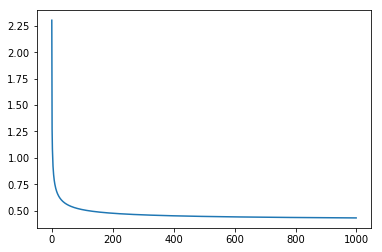

In [19]:
plt.plot(losses)

In [20]:
data = pd.read_csv('Medical_data.csv')
X = data.as_matrix()
print(X)
y=np.empty(X.shape[0])
for i in range(X.shape[0]):
    if(X[i,0]=='HEALTHY'):
        y[i]=0
    if(X[i,0]=='SURGERY'):
        y[i]=1
    if(X[i,0]=='MEDICATION'):
        y[i]=2
print(y.shape)
X = X[:,1:4]
y=np.array(y,dtype='int')

[['HEALTHY' 1.6315155608144196 -0.26444658130172355 2.534567146651425]
 ['SURGERY' 0.15395105426389907 1.419533481505174 1.3331207912724836]
 ['HEALTHY' 2.021729118164318 0.26204637889999405 2.8799717380508727]
 ...
 ['HEALTHY' 0.19320188275265227 0.36039894430698144 1.8676445668171464]
 ['HEALTHY' 1.6840959730399991 -0.02321819895892971 3.306257682435044]
 ['MEDICATION' 0.9752179047232428 2.305958926888452 0.22982688347681815]]
(3000,)


c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [21]:
data_test = pd.read_csv('test_medical.csv')
X_test = data_test.as_matrix()
# print(X)
y_test=np.empty(X_test.shape[0])
for i in range(X_test.shape[0]):
    if(X_test[i,0]=='HEALTHY'):
        y_test[i]=0
    if(X_test[i,0]=='SURGERY'):
        y_test[i]=1
    if(X_test[i,0]=='MEDICATION'):
        y_test[i]=2
print(y_test.shape)  
X_test = X_test[:,1:4]
y_test=np.array(y_test,dtype='object')

(3000,)


c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [22]:
train=X
y_train=y
test=X_test
print(y_train)

[0 1 0 ... 0 0 2]


In [23]:
w = np.zeros([train.shape[1],len(np.unique(y_train))])
lamda = 0
iterations = 1000
alpha = 1e-1
losses = []
for i in range(0,iterations):
    loss,grad = getLoss(w,train,y_train,lamda)
    losses.append(loss)
    w = w - (alpha * grad)
    print(i)
print(loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
prob,pred = getProbsAndPreds(test)
np.sum(pred==y_test)

2408

In [25]:
print(mtr.accuracy(y_test, pred))
print(mtr.scores(y_test,pred))

0.8026666666666666
(0.8035782567449131, 0.8026666666666668, 0.8026879982758967)


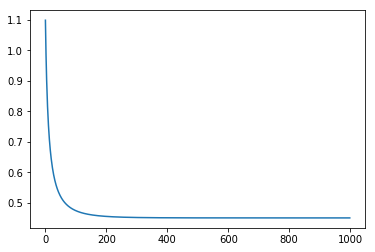

In [26]:
plt.plot(losses)

In [27]:
data = pd.read_csv('railwayBookingList.csv')

dict_class={'FIRST_AC':0,'SECOND_AC':1,'THIRD_AC':2,'NO_PREF':3}
for i in range(data.shape[0]):
    data['preferredClass'][i]=dict_class[data['preferredClass'][i]]
data['sex'][(data['sex']=='male')]=0
data['sex'][(data['sex']=='female')]=1
sorted_b=np.sort(np.array(data['budget'].unique()))
for x,i in enumerate(sorted_b):
    data['budget'][data['budget']==i]=x
y=data['boarded']
X = data.as_matrix()
X=X[:-1,2:]
y=y[:-1]
y=np.array(y)
print(X.shape)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    train, y_train = X[train_index], y[train_index]
    test, y_test = X[test_index], y[test_index]
y_train=np.array(y_train)
train=np.array(train)
test=np.array(test)
y_test=np.array(y_test)


c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\sarve\appdata\local\program

(1309, 5)


c:\users\sarve\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [28]:
w = np.zeros([train.shape[1],len(np.unique(y_train))])
lamda = 0
iterations = 1000
alpha = 1e-1
losses = []
for i in range(0,iterations):
    loss,grad = getLoss(w,train,y_train,lamda)
    losses.append(loss)
    w = w - (alpha * grad)
    print(i)
print(loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

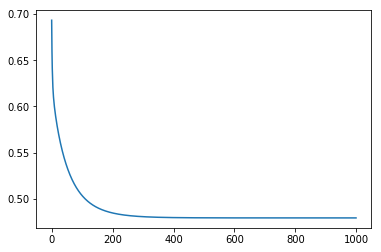

In [29]:
plt.plot(losses)

In [30]:
prob,pred = getProbsAndPreds(test)
print(mtr.accuracy(y_test, pred))
print(mtr.scores(y_test,pred))

0.7977099236641222
(0.7854613177016547, 0.7885802469135803, 0.7869036109448613)
